## URL of the selected forum

**"https://forums.edmunds.com/discussion/2444/general/x/what-car-is-right-for-me-help-me-choose"**

In [41]:
## intalling required packages and drivers

## General libraries
import sys
import pandas as pd
import numpy as np
import math
import re
import string
import itertools
import warnings
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

## Required for scraping
!pip install selenium
!apt install -yq chromium-chromedriver

from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException

sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# For accessing Google Drive
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## For text analytics
!pip install -U -q nltk

import nltk
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.manifold import MDS

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Reading package lists...
Building dependency tree...
Reading state information...
chromium-chromedriver is already the newest version (78.0.3904.70-0ubuntu0.18.04.2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

These functions are used to download and upload files from and to Google Drive respectively. 

In [0]:
# def download_file(file_id, file_name):
#     downloaded = drive.CreateFile({'id': file_id})
#     downloaded.GetContentFile(file_name)

# def upload_file(file_name):
#     uploaded = drive.CreateFile({'title': file_name})
#     uploaded.SetContentFile(file_name)
#     uploaded.Upload()

In [0]:
# download_file('14NQIiinQVn5HlKsMsR95arQ_5D3-kPRl','comments_data.csv')
# download_file('1xk7WSKz-BhzcMHdvIkDhZ8MPsWUG-eHy','models.csv')
#download_file('1pJiiRXvt8y91EYwA31jKhra8MLh3C9of','clean_comments_data.csv')

## Scrapper
Scrapper class takes in selenium driver, base path for the webpage (without page numbers), x_paths for elements to be scraped, x_path for elements containing page numbers, and index of x_path string which will change for multiple elements on the page.

In [0]:
class Scraper():
  def __init__(self, driver, base_url, xpaths, pages_xpath, split_index):
    ## Initializing class variables
    self.base_url = base_url
    self.driver = driver
    self.xpaths = xpaths
    self.pages_xpath = pages_xpath
    self.split_index = split_index
    self.page_count = 81
    self.content = pd.DataFrame(columns=['username','posts','created_at','message'])
    self.flag = True

  ## Extracting relevent content from the forum
  def get_content(self):
    ## For every page in the forum
    for page in range(self.page_count+1):
      ## Run until no more post is left on a page
      self.flag = True
      ## Keeping count of number of posts in a page
      post = 0
      ## Page extension of the URL. Will be a suffix in the url for page number
      page_number = "/p"+str(page+1)
      ## Extract the entire page
      self.driver.get(self.base_url+page_number)
      if(page%5==0):
          print(page)
      ## Run this loop while there are posts on the page
      while self.flag:
        post+=1
        ## Extract relevant elements and store in a dataframe
        name_path = self.xpaths['name'][:self.split_index]+str(post)+self.xpaths['name'][self.split_index+1:]
        posts_path = self.xpaths['posts'][:self.split_index]+str(post)+self.xpaths['posts'][self.split_index+1:]
        datetime_path = self.xpaths['datetime'][:self.split_index]+str(post)+self.xpaths['datetime'][self.split_index+1:]
        message_path = self.xpaths['message'][:self.split_index]+str(post)+self.xpaths['message'][self.split_index+1:]
        name = self.get_name_if_exists(name_path)
        posts = self.get_posts_if_exists(posts_path)
        created_at = self.get_datetime_if_exists(datetime_path)
        message = self.get_message_if_exists(message_path)
        if(post<=50):
          self.content = self.content.append({'username':name,'posts':posts,'created_at':created_at,'message':message},ignore_index=True)

  ## Check if name element is present and extract
  def get_name_if_exists(self, path):
    try:
        element = self.driver.find_element_by_xpath(path)
    except NoSuchElementException:
        self.flag = False
        return ''
    return element.text

  ## Check if posts element is present and extract
  def get_posts_if_exists(self, path):
    try:
        element = self.driver.find_element_by_xpath(path)
    except NoSuchElementException:
        self.flag = False
        return ''
    return element.text

  ## Check if datetime element is present and extract
  def get_datetime_if_exists(self, path):
    try:
        element = self.driver.find_element_by_xpath(path)
    except NoSuchElementException:
        self.flag = False
        return ''
    return element.get_attribute('datetime')


  ## Check if message element is present and extract
  def get_message_if_exists(self, path):
    try:
        element = self.driver.find_element_by_xpath(path)
    except NoSuchElementException:
        self.flag = False
        return ''
    return element.text

## Data Cleaning
Data cleaning class tokenizes words in the comments, converts them to lower, removes leading and trailing whitespaces, punctuations, non-alphanumerics words, short words, and finally stems the words.

It takes a dataframe with message column, name of the message column, list of stopwords and list of punctuations.

In [0]:
class DataCleaning():
  def __init__(self, data, message_column, stopwords, punctuations):
    ## Initializing class variables
    self.data = data
    self.stopwords = stopwords
    self.punctuations = punctuations
    self.clean_data = self.data[message_column].apply(word_tokenize)
    self.table = str.maketrans('', '', self.punctuations)
    self.porter = PorterStemmer()

  def get_clean_data(self):
    ## make all words lowercase
    self.output = self.clean_data.apply(self.convert_to_lower)
    ## remove punctuations
    self.output = self.output.apply(self.remove_punctuations)
    ## remove non-alphanumeric words
    self.output = self.output.apply(self.remove_non_alphanumeric)
    ## remove stop words
    self.output = self.output.apply(self.remove_stopwords)
    ## remove short words
    self.output = self.output.apply(self.remove_short_words)
    ## stemming words
    #self.output = self.output.apply(self.remove_stem_words)

  def convert_to_lower(self, row):
    first = [word.lower() for word in row]
    second = [word.strip() for word in first]
    return second

  def remove_punctuations(self, row):
    return [word.translate(self.table) for word in row]

  def remove_non_alphanumeric(self, row):
    return [word for word in row if word.isalpha()]

  def remove_stopwords(self, row):
    return [word for word in row if not word in self.stopwords]

  def remove_short_words(self, row):
    return [word for word in row if len(word)>2]

  def remove_stem_words(self, row):
    return [self.porter.stem(word) for word in row]

## Lift Calculator
Lift Calculator calculates lift between different attributes.

It takes a dataframe at word-post level i.e. every row is a word of a post identified by 'id' column, list of brands, name of word column, name of brand column, and name of id column.

In [0]:
class LiftCalculator():
  ## Initializing class variables
  def __init__(self,data,brand_list,word_column,brand_column,id_column):
    self.data = data
    self.brand_list = brand_list
    self.word_column = word_column
    self.brand_column = brand_column
    self.id_column = id_column
    self.n = len(self.data[self.id_column].unique())
    ## This will store all the lift values between different combination of attributes
    self.lift = pd.DataFrame(columns={'brand_list_1','brand_list_2','lift_score'})
    ## This will store all the 1/lift values between different combination of attributes
    self.lift_rev = pd.DataFrame(columns={'brand_list_1','brand_list_2','lift_score'})

  ## Calculating lift
  def get_lift(self):
    ## Filtered data filters out rows where the word is a brand
    self.filtered_data = self.data[self.data[self.brand_column]==1]
    ## From the list of brand brand_combinations create all combination of brands, for example, if brand_list=['honda','bmw','audi']
    ## brand_combination will be [('honda','bmw'),('honda','audi'),('bmw','audi')]
    brand_combinations = list(itertools.combinations(self.brand_list,2))
    ## For all combination of brands
    for combination in brand_combinations:
      ## Count number of posts in which brand 1 occurs, count number of posts in which brand 2 occurs
      individual_count = self.get_individual_count(combination)
      ## Count number of posts in which brand 1 and brand 2 occur together
      joint_count = self.get_joint_count(combination)
      ## Calculate lift
      lift = (self.n*joint_count)/(individual_count[0]*individual_count[1])
      ## Calculate 1/lift which is a measure of dissimilarity used to create MDS
      if(lift==0):
        lift_rev = np.nan
      else:
        lift_rev = 1/(lift)
      ## Append lift value to lift dataframe with both combinations. This is used to create pivot table
      self.lift = self.lift.append({'brand_list_1':combination[0],'brand_list_2':combination[1],'lift_score':lift},ignore_index=True)
      self.lift = self.lift.append({'brand_list_1':combination[1],'brand_list_2':combination[0],'lift_score':lift},ignore_index=True)
      ## Append 1/lift value to reverse lift dataframe with both combinations. This is used to create pivot table
      self.lift_rev = self.lift_rev.append({'brand_list_1':combination[0],'brand_list_2':combination[1],'lift_score':lift_rev},ignore_index=True)
      self.lift_rev = self.lift_rev.append({'brand_list_1':combination[1],'brand_list_2':combination[0],'lift_score':lift_rev},ignore_index=True)
    ## Create lift pivot
    self.lift_pv = self.get_pivot(self.lift)
    ## Create lift reverse pivot
    self.lift_pv_rev = self.get_pivot(self.lift_rev)

  ## Creating pivot table
  def get_pivot(self, df):
    lift_pv = df.pivot('brand_list_1', 'brand_list_2', 'lift_score')
    lift_pv.reset_index(inplace=True)
    lift_pv = lift_pv.fillna(0)
    lift_pv.set_index('brand_list_1',inplace=True)
    return lift_pv

  ## Counting individual occurences
  def get_individual_count(self, combination):
    brand1 = self.filtered_data[self.filtered_data[self.word_column]==combination[0]].shape[0]
    brand2 = self.filtered_data[self.filtered_data[self.word_column]==combination[1]].shape[0]
    return (brand1,brand2)

  ## Coounting joint occurences
  def get_joint_count(self, combination):
    brandall = self.filtered_data[(self.filtered_data[self.word_column]==combination[0])|
                                  (self.filtered_data[self.word_column]==combination[1])]
    brandall['row_num'] = brandall.groupby(self.id_column).cumcount()+1
    bothbrands = brandall[brandall['row_num']==2].shape[0]
    return bothbrands

## Attributes
Attributes gives a dataframe identifying what all words are attributes of the brand.

It takes a dataframe at word-post level i.e. every row is a word of a post identified by 'id' column, list of attributes, list of top brands,synonyms falg and number of top attributes required.

In [0]:
class Attributes():
  ## Initializing class variables
  def __init__(self,data,attribute_list,top_brands,synonym_flag=False,top=0,aspiration=False):
    self.data = data
    self.attribute_list = attribute_list
    self.synonym_flag = synonym_flag
    self.synonyms = dict()
    self.top = top
    self.top_brands = top_brands
    self.aspiration = aspiration

  ## Get synonyms for all the attributes
  def get_synonyms(self):
    for word in self.attribute_list:
      syn_temp = list()
      for syn in wordnet.synsets(word):
        for lem in syn.lemmas():
          syn_temp.append(lem.name())
      self.synonyms.update({word:syn_temp})

  ## Update words data with synonyms
  def update_data(self):
    if(self.synonym_flag): 
      self.get_synonyms()
      attribute_frame = pd.DataFrame(columns=['master','synonym']) 
      if(self.aspiration):
        for keyword in list(self.synonyms.keys()) :
          for word in self.synonyms[keyword]:
            attribute_frame = attribute_frame.append({'master':'dream','synonym':word},ignore_index=True)
      else:
        for keyword in list(self.synonyms.keys()) :
          for word in self.synonyms[keyword]:
            attribute_frame = attribute_frame.append({'master':keyword,'synonym':word},ignore_index=True)
      attribute_frame = attribute_frame.drop_duplicates()
      self.data = pd.merge(self.data,attribute_frame,left_on='word',right_on='synonym',how='left')
      self.data = self.data.fillna('')
      self.data['attribute_flag'] = self.data['synonym'].apply(lambda x: 1 if x!='' else 0)
      self.data['new_word'] = self.data['word'].apply(lambda x: x)
      self.data = pd.concat([self.data,self.data.apply(lambda x: x['new_word'] if x['attribute_flag']==0 else x['master'],axis=1)],axis=1)
      del self.data['new_word']
      self.data = self.data.rename(columns={0:'new_word'})

  ## Get top 5 attributes
  def get_top_five_attributes(self):
    self.update_data()
    self.top_attributes = self.data[self.data['attribute_flag']==1]
    self.top_attributes = pd.DataFrame(self.top_attributes['new_word'].value_counts().head(self.top)).reset_index()
    self.top_attributes.columns = ['attribute','count']

  ## Get posts where both attibutes and brands are present
  def get_common_data(self):
    self.update_data()
    self.data_with_brand_attributes = self.data[(self.data['new_word'].isin(self.top_brands))|(self.data['attribute_flag']==1)]
    both_present = self.data_with_brand_attributes.groupby('id').agg({'brand':'sum','attribute_flag':'sum'}).reset_index()
    both_present.columns = ['id','brand_count','attribute_count']
    self.data_with_brand_attributes = pd.merge(self.data_with_brand_attributes,both_present,on='id',how='left')
    self.data_with_brand_attributes['filter_flag'] = self.data_with_brand_attributes.apply(lambda x: 1 if x['brand_count']!=0 & x['attribute_count']!=0 else 0,axis=1)

In [0]:
class AttributeLiftCalculator():
    def __init__(self,data,attribute_list,brand_list,brand_column,brand_flag,attr_column,attr_flag,id_column):
        self.attribute_list = attribute_list
        self.data = data
        self.brand_list = brand_list
        self.word_column = brand_column
        self.brand_column = brand_flag
        self.attr_column = attr_column
        self.attr_flag = attr_flag
        self.id_column = id_column
        self.n = len(self.data[self.id_column].unique())
        self.lift = pd.DataFrame(columns={'brand_list_1','brand_list_2','lift_score'})

    def get_lift(self):
        self.filtered_data = self.data[(self.data[self.brand_column]==1)|(self.data[self.attr_flag]==1)]
        brand_combinations = list(itertools.product(self.brand_list,self.attribute_list))
        for combination in brand_combinations:
            individual_count = self.get_individual_count(combination)
            joint_count = self.get_joint_count(combination)
            try:
                lift = (self.n*joint_count)/(individual_count[0]*individual_count[1])
            except ZeroDivisionError:
                lift = 0
            self.lift = self.lift.append({'brand_list_1':combination[0],'brand_list_2':combination[1],'lift_score':lift},ignore_index=True)
        self.lift = self.lift[self.lift['lift_score']!=0]

    def get_individual_count(self, combination):
        brand1 = self.filtered_data[self.filtered_data[self.word_column]==combination[0]].shape[0]
        brand2 = self.filtered_data[self.filtered_data[self.attr_column]==combination[1]].shape[0]
        return (brand1,brand2)
  
    def get_joint_count(self, combination):
        brandall = self.filtered_data[(self.filtered_data[self.word_column]==combination[0])|
                                      (self.filtered_data[self.attr_column]==combination[1])]
        brandall['row_num'] = brandall.groupby(self.id_column).cumcount()+1
        bothbrands = brandall[brandall['row_num']==2].shape[0]
        return bothbrands

## Web Scraping

In [0]:
## Initial parameters setting
base_url = "https://forums.edmunds.com/discussion/2444/general/x/what-car-is-right-for-me-help-me-choose"
driver = webdriver.Chrome('chromedriver', options=chrome_options)
pages_xpath = '/html/body/div[1]/main/div/div[3]/div[5]/span/span'
xpaths = {'name':'/html/body/div[1]/main/div/div[3]/div[5]/div[1]/ul/li[1]/div/div[2]/div[1]/span[1]/a[2]',
          'posts':'/html/body/div[1]/main/div/div[3]/div[5]/div[1]/ul/li[1]/div/div[2]/div[1]/span[2]/span/b',
          'datetime':'/html/body/div[1]/main/div/div[3]/div[5]/div[1]/ul/li[1]/div/div[2]/div[2]/span/a/time',
          'message':'/html/body/div[1]/main/div/div[3]/div[5]/div[1]/ul/li[1]/div/div[3]/div/div[1]'}

## Creating scrapper class object and scraping the forum
scraper = Scraper(driver,base_url,xpaths,pages_xpath,54)
scraper.get_content()

## Storing scraped data
data = scraper.content

## Data Cleaning

In [0]:
## Cleaning the scraped data
data['created_at'] = pd.to_datetime(data['created_at'])
data['posts'] = data['posts'].str.replace(',','')
data['posts'] = data['posts'].str.strip()
data = data[data['message'].notnull()]
data = data.reset_index()
del data['index']

## Reading models files
model = pd.read_csv('models.csv',names=['brand','model'])

## Stop words list
stop_words = set(stopwords.words('english'))

## Creating DataCleaning class object and cleaning all the comments
cleaner = DataCleaning(data=data,stopwords=stop_words,punctuations=string.punctuation)
cleaner.get_clean_data()

messages = cleaner.output.copy()

## Replacing model name with respective brands
for row in range(len(messages)):
  for brand in range(model.shape[0]):
    messages[row] = [word if word!=model.iloc[brand,1] else model.iloc[brand,0] for word in messages[row]]

data['cleaned_message'] = messages

In [0]:
## Creating a list of unique brands
brands = pd.DataFrame(model['brand'].drop_duplicates())


## Converting into a dataframe with words, count of words, unique comment id and post features. 
## This dataframe can be used for frequency count.
word_df = pd.DataFrame()

for row in range(data.shape[0]):
  freq = nltk.FreqDist(data.iloc[row,4])
  temp = pd.DataFrame.from_dict(freq,orient='index',columns=['count']).reset_index()
  temp['id'] = row+1
  temp['username'] = data.iloc[row,0]
  temp['posts'] = data.iloc[row,1]
  temp['created_at'] = data.iloc[row,2]
  word_df = word_df.append(temp,ignore_index=True)

word_df.columns = ['brand','count','id','username','posts','created_at']

## Count of brand occurences

In [0]:
## Reading Words Data

words_df = pd.read_csv("words_data.csv",sep='\t')

In [0]:
word_df = pd.merge(word_df,brands,left_on='word',right_on='brand',how='left')
word_df['brand'] = word_df['brand'].replace(math.nan,0)
word_df['brand'] = np.where(word_df['brand']!=0,1,word_df['brand'])
word_df['brand'] = word_df['brand'].astype(int)

car           2145
honda         1097
toyota         837
nissan         538
hyundai        506
sedan          438
ford           403
chevrolet      362
seat           360
problem        344
volkswagen     332
acura          325
mazda          277
bmw            268
subaru         258
Name: word, dtype: int64


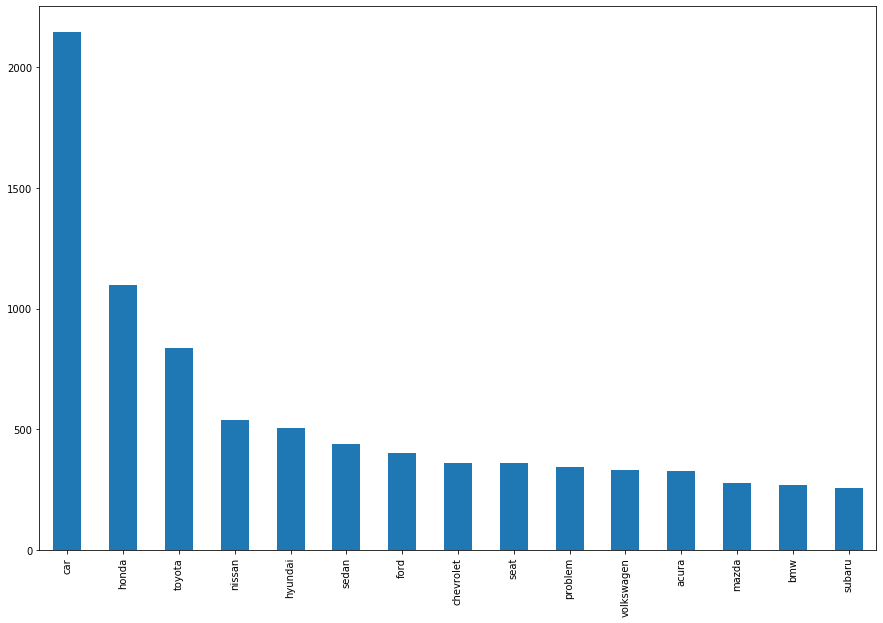

In [133]:
brands_df = word_df[word_df['brand']==1]
top_frequency = brands_df['word'].value_counts()
print(top_frequency.head(15))
top_frequency.head(15).plot(kind='bar',figsize=[15,10])

### We removed car, sedan, seat, and problem from the top brands list since they are not brands.

### Below is the list of top 10 brands

In [0]:
top_brands = ['honda', 'toyota', 'nissan', 'hyundai', 'ford', 'chevrolet', 'volkswagen', 'acura', 'mazda', 'bmw']

## Calculating Lift Between Brands
Call the lift class created above for this.

In [149]:
lc = LiftCalculator(word_df,top_brands,'word','brand','id')
lc.get_lift()
lift = lc.lift_pv

lift_for_plotting = lc.lift_pv_rev

print(lift)

brand_list_2     acura       bmw  chevrolet  ...    nissan    toyota  volkswagen
brand_list_1                                 ...                                
acura         0.000000  2.433375   0.339907  ...  1.120681  1.014359    0.852428
bmw           2.433375  0.000000   0.700740  ...  0.943003  1.087479    1.123618
chevrolet     0.339907  0.700740   0.000000  ...  1.375737  1.702578    1.297685
ford          0.915976  0.814581   2.987888  ...  1.217329  1.647918    1.733550
honda         1.503025  0.992962   1.258770  ...  1.687182  1.846652    1.306633
hyundai       0.534983  0.442341   1.506404  ...  1.601198  1.727931    1.452087
mazda         1.332630  0.808031   1.316064  ...  1.395381  1.724830    1.652407
nissan        1.120681  0.943003   1.375737  ...  0.000000  1.616274    1.544828
toyota        1.014359  1.087479   1.702578  ...  1.616274  0.000000    1.309572
volkswagen    0.852428  1.123618   1.297685  ...  1.544828  1.309572    0.000000

[10 rows x 10 columns]


In [150]:
lift_for_plotting

brand_list_2,acura,bmw,chevrolet,ford,honda,hyundai,mazda,nissan,toyota,volkswagen
brand_list_1,,,,,,,,,,
acura,0.000000,0.410952,2.941985,1.091731,0.665325,1.869217,0.750396,0.892315,0.985844,1.173119
bmw,0.410952,0.000000,1.427063,1.227625,1.007087,2.260699,1.237576,1.060442,0.919558,0.889982
chevrolet,2.941985,1.427063,0.000000,0.334685,0.794427,0.663833,0.759841,0.726883,0.587345,0.770603
ford,1.091731,1.227625,0.334685,0.000000,0.610776,0.515073,0.443091,0.821471,0.606826,0.576851
honda,0.665325,1.007087,0.794427,0.610776,0.000000,0.657845,0.649455,0.592704,0.541520,0.765326
hyundai,1.869217,2.260699,0.663833,0.515073,0.657845,0.000000,0.625880,0.624532,0.578727,0.688664
mazda,0.750396,1.237576,0.759841,0.443091,0.649455,0.625880,0.000000,0.716650,0.579767,0.605178
nissan,0.892315,1.060442,0.726883,0.821471,0.592704,0.624532,0.716650,0.000000,0.618707,0.647321
toyota,0.985844,0.919558,0.587345,0.606826,0.541520,0.578727,0.579767,0.618707,0.000000,0.763608


## MDS Map
This will create MDS map for various brands and their respective lifts.

,brand,x,y
0,acura,0.793861,0.433528
1,bmw,0.388885,0.797829
2,chevrolet,-0.630239,-0.258140
3,ford,-0.166852,-0.091284
4,honda,0.269657,0.001683
5,hyundai,-0.360128,-0.623491
6,mazda,0.194397,-0.199578
7,nissan,-0.208932,-0.067331
8,toyota,0.010601,-0.283068
9,volkswagen,-0.291251,0.289853


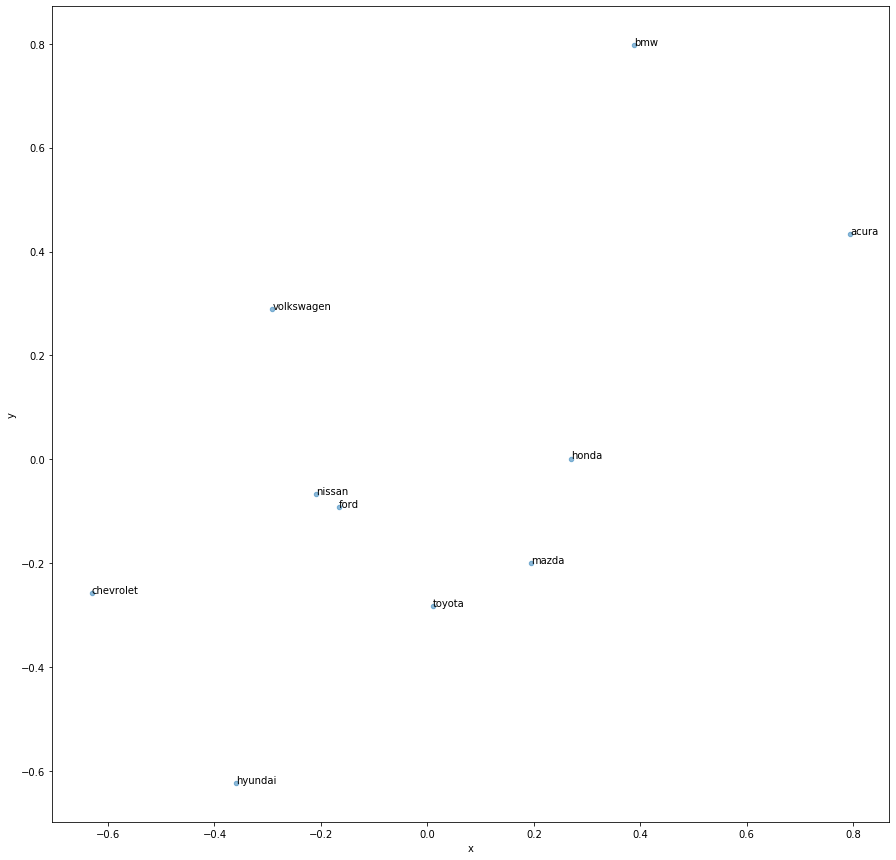

In [152]:
def get_mds(mds, df, plot=True):
    mds_score = mds.fit_transform(df)
    mds_scoredf = pd.DataFrame()
    mds_scoredf['brand'] = df.index.values
    mds_scoredf['x'] = mds_score[:,0]
    mds_scoredf['y'] = mds_score[:,1]
    
    if plot==True:
        ax = mds_scoredf.plot.scatter(x='x', y='y', alpha=0.5,figsize=(15,15))
        for i, txt in enumerate(mds_scoredf['brand']):
            ax.annotate(txt, (mds_scoredf.x.iat[i],mds_scoredf.y.iat[i]))

    return (mds_scoredf)

mds = MDS(n_components=3, metric=True, n_init=4, max_iter=300, 
          verbose=0, eps=0.001, n_jobs=None, 
          random_state=13, dissimilarity="precomputed")

get_mds(mds,lift_for_plotting,plot=True)

People are more likely to talk about ford than a chevrolet in the asian car brand cluster of- nissan, mazda, toyota, honda 

People looking for entry level luxury cars mostly compare Acura and BMW

Volkswagen and Hyundai have created their own separate niche segments and are not frequqently compared with other brands

## Most Important Attributes

In [0]:
## list of attributes
attributes=['speed','performance','wheels','size','practical','highend','luxury','reliable','premium','maintenance','attractive','sport',
            'classy','harsh','sunroof','comfortable','quality','price','airbags','spin','hybrid','efficient','sexy',
            'weight','engine','stick','shift','europena','american','transmission','looking','steering','torque','powerful','interior']

## Initializing attributes class to get for top 5 brands
attributes_object = Attributes(word_df,attributes,['honda', 'toyota', 'nissan', 'hyundai', 'ford'],True,5)

attributes_object.get_common_data()

## Dataframe for brands and attributes
brand_attribute_data = attributes_object.data_with_brand_attributes

looking     2054
stick       1413
price        997
reliable     461
sport        446
Name: new_word, dtype: int64


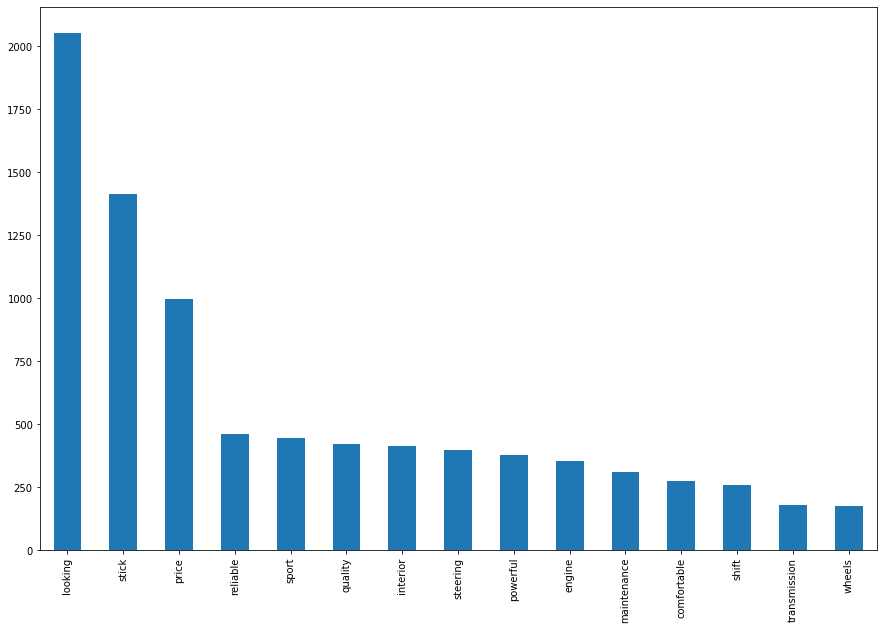

In [155]:
all_attributes = brand_attribute_data[brand_attribute_data['attribute_flag']==1]
all_attributes = all_attributes['new_word'].value_counts()
print(all_attributes.head())
all_attributes.head(15).plot(kind='bar',figsize=[15,10])

## Lift for Brands and their Attributes

In [0]:
attributes = list(brand_attribute_data['new_word'].unique())

In [0]:
alc = AttributeLiftCalculator(brand_attribute_data,attributes,top_brands,'word','brand','new_word','attribute_flag','id')
alc.get_lift()

In [160]:
lift = alc.lift
lift.rename(columns={'brand_list_2':'attributes','brand_list_1':'brand'},inplace=True)
lift = lift[['brand','attributes','lift_score']]
lift = lift[~lift['attributes'].isin(top_brands)]
lift = lift.sort_values(['brand','lift_score'],ascending=False)
lift['rank'] = lift.groupby(['brand'])['lift_score'].rank(method='dense',ascending=False)
lift = lift[lift['rank']<=5]

## Top 5 attributes by brand
lift

,brand,attributes,lift_score,rank
70,toyota,sexy,2.692951,1.0
69,toyota,hybrid,2.096411,2.0
36,toyota,quality,1.579397,3.0
55,toyota,comfortable,1.533213,4.0
58,toyota,speed,1.514785,5.0
78,nissan,attractive,2.285231,1.0
75,nissan,looking,1.826572,2.0
92,nissan,sunroof,1.770250,3.0
86,nissan,interior,1.700124,4.0
97,nissan,steering,1.630458,5.0


1. **Toyota:** 
When people consider Hybrid cars, they consider Toyota the most. In addtion to this, Honda Hybrid cards are also talked about a lot. This might be due to the launch of Honda Civic hybrid. So, Toyota should see sentiments of its own hybrid cars and compare it with market sensiments of Honda hybrid cars. There may be a strong correlation between these. Totoya is also known for its quality. People buying new cars highly regard this attribute of Toyota.

2. **Nissan:**People mention Nissan for its looks and design. Compared to other top brands Nissan should design marketing campaigns to showcase how its cars offer smooth drive and performance.

3. **Hyundai:** People recommend Hyundai because of low price and comfort. People who want to buy a car with sunroof are often recommended Hyndai.

4. **Honda:**While people associate honda with looks and attractiveness, in terms of comfort it is not talked about frequently. Infact people have used the term harsh for honda in general.

5. **Ford:** is considered to be classy by many bloggers. So Ford can act on this attribute to design marketing campaigns around how classy its cars are.

## Most Aspirational Brands

To get top aspired brands, followed the below mentioned steps:
1. Create a list of aspiration words.
2. Find the words that match these aspiration words in the dataframe and replace them with a common word "dream".
3. Find lift between all the brands and "dream" word.
4. Sort the lift values in descending order to find top aspired brands.

In [131]:
aspirations = ['want','like','love','need','desire','wish','fancy','prefer','hope','urges','yearn','yearning','target','aim']

all_brands = ['honda', 'toyota', 'nissan', 'hyundai', 'ford',
       'chevrolet', 'volkswagen', 'acura', 'mazda', 'bmw',
       'subaru', 'audi', 'buick', 'kia', 'volvo', 'infiniti', 'dodge',
       'mercedes', 'chrysler', 'pontiac', 'cadillac', 'saturn', 'mitsubishi',
       'mercury', 'suzuki', 'lincoln']

## Initializing attributes class to get for top 5 brands
attributes_object = Attributes(word_df,aspirations,all_brands,True,5,True)

attributes_object.get_common_data()

## Dataframe for brands and aspirations
brand_attribute_data = attributes_object.data_with_brand_attributes

alc = AttributeLiftCalculator(brand_attribute_data,['dream'],all_brands,'word','brand','new_word','attribute_flag','id')
alc.get_lift()

lift = alc.lift
lift.rename(columns={'brand_list_2':'attributes','brand_list_1':'brand'},inplace=True)
lift = lift[['brand','attributes','lift_score']]
lift = lift.sort_values(['brand','lift_score'],ascending=False)
lift['rank'] = lift.groupby(['brand'])['lift_score'].rank(method='dense',ascending=False)
lift = lift[lift['rank']<=5]

## Most aspirational brands
lift.sort_values('lift_score',ascending=False)

,brand,attributes,lift_score,rank
25,lincoln,dream,44.433385,1.0
24,suzuki,dream,40.373250,1.0
23,mercury,dream,32.879826,1.0
22,mitsubishi,dream,25.390506,1.0
20,cadillac,dream,12.734355,1.0
21,saturn,dream,12.734355,1.0
19,pontiac,dream,10.644548,1.0
18,chrysler,dream,9.805684,1.0
17,mercedes,dream,9.684225,1.0
16,dodge,dream,9.109933,1.0
